# Logistic Model

In [307]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
import itertools

import sys
assert(sys.version_info.major==3), print(sys.version)

# Data and Stats packages
import numpy as np
import pandas as pd
from sklearn import metrics, datasets
from sklearn.model_selection import train_test_split
import statsmodels.api as sm # RUNNING FOR ME (MSR)

# Visualization packages
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (13.0, 6.0)

import io
import itertools
import warnings
warnings.filterwarnings("ignore")

### 1) Separate Dependent and Independent Predictors

In [308]:
# Read in the dataframe
df = pd.read_csv('training_data_v1.csv', skiprows=0)

In [309]:
df_1 = df.copy()

df_1 = df_1.drop(columns=['predictor','Charged Off','Y','N'],axis=1)

In [310]:
df_1['zip_code'] = df['zip_code'].astype(str)

In [311]:
df_new = pd.DataFrame()
df_new = pd.get_dummies(df_1['zip_code'])
df_1 = df_1.drop(['zip_code'],axis=1)
df_1 = pd.concat([df_1,df_new], axis=1)

In [313]:
sample = df_1.sample(frac=0.01)

### Clean Dataset and Impute Missing Data

In [314]:
# Set all Nan's to 0

for i in sample.index:
    for j in sample.columns:
        if pd.isnull(sample.at[i,j]):
            sample.at[i,j] = 0

In [315]:
x_train, x_test, y_train, y_test = train_test_split(sample.drop(columns=['Fully Paid'],axis=1), 
                                                    sample['Fully Paid'], test_size=0.15, random_state=42)

### 3) Select Most Significant Predictors Using Random Forest Regressor

In [319]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np

rf = RandomForestRegressor()
rf.fit(x_train, y_train)

names = x_train.columns
performance = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

purity = 0
purity_list = []
selected_cols = []

for i in range(0,40):
    purity = purity + performance[i][0]
    purity_list.append(purity)
    selected_cols.append(performance[i][1])
    
selected_cols.append('Fully Paid')

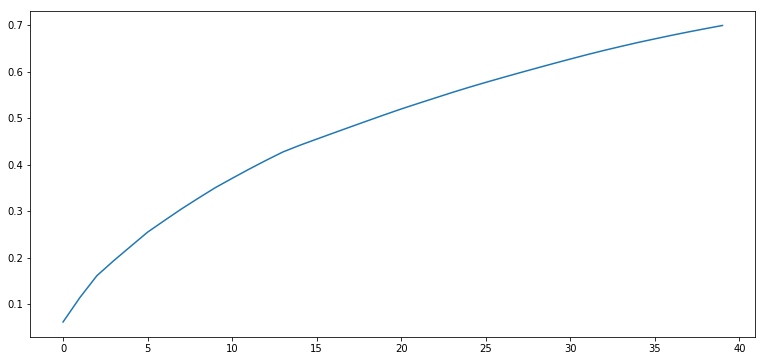

In [320]:
plt.plot(purity_list)

In [321]:
selected_cols, purity_list

(['sub_grade',
  'dti',
  'int_rate',
  'total_acc',
  'revol_bal',
  'max_bal_bc',
  'open_rv_24m',
  'installment',
  'annual_inc',
  'total_bc_limit',
  'num_actv_bc_tl',
  'total_rev_hi_lim',
  'total_bal_il',
  'total_bal_ex_mort',
  'num_actv_rev_tl',
  'num_op_rev_tl',
  'funded_amnt',
  'il_util',
  'tot_hi_cred_lim',
  'mths_since_rcnt_il',
  'percent_bc_gt_75',
  'bc_open_to_buy',
  'open_acc_6m',
  'num_tl_op_past_12m',
  'num_il_tl',
  'total_cu_tl',
  'num_rev_accts',
  'mort_acc',
  'all_util',
  'bc_util',
  'open_rv_12m',
  'total_il_high_credit_limit',
  'num_bc_sats',
  'num_rev_tl_bal_gt_0',
  '8 years',
  'tot_cur_bal',
  'pct_tl_nvr_dlq',
  'avg_cur_bal',
  'revol_util',
  'num_bc_tl',
  'Fully Paid'],
 [0.0619,
  0.1146,
  0.1614,
  0.19379999999999997,
  0.22449999999999998,
  0.2551,
  0.2802,
  0.3049,
  0.3281,
  0.3507,
  0.3708,
  0.3905,
  0.4094,
  0.4275,
  0.4419,
  0.4552,
  0.4684,
  0.4815,
  0.4945,
  0.5074,
  0.52,
  0.5319,
  0.5436000000000001,
 

In [322]:
df_2 = df_1[selected_cols]

In [323]:
sample2 = df_2.sample(frac=0.1)

In [324]:
for i in sample2.index:
    for j in sample2.columns:
        if pd.isnull(sample2.at[i,j]):
            sample2.at[i,j] = 0

### 4) Instantiate and Fit Logistic Model

In [326]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(sample2.drop(columns=['Fully Paid'],axis=1), 
                                                    sample2['Fully Paid'], test_size=0.15, random_state=42)

In [327]:
from sklearn.linear_model import LogisticRegressionCV

logistic = LogisticRegressionCV(Cs=1000,penalty='l2')
logistic.fit(x_train2, y_train2)

LogisticRegressionCV(Cs=1000, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [328]:
logistic.score(x_test2, y_test2)

0.75

### 5) Evaluate Average Interest Returns

In [329]:
# x_test2['int_rate']
expected_interest = []
predicted_prob = logistic.predict_proba(x_test2)
for i in range(0,len(x_test2)):
    # Expected interest is predicted probability times interest rate
    expected_interest.append(predicted_prob[i][1]*x_test2.iloc[i]['int_rate'])

In [341]:
exp_int_df = pd.DataFrame(data = expected_interest, columns=['EI'])
top_10_percent = round(len(x_test2)*.1)
best_ten_loans = exp_int_df.sort_values('EI',ascending=False).index[0:top_10_percent]

best_ten_loans

Int64Index([1112, 1081,  684,  196,  550,  825,  638, 1011,  868,  935,
            ...
             420,  617,  123, 1126,  440, 1174, 1205,   48,  398,  572],
           dtype='int64', length=122)

In [343]:
successes = []
for i in best_ten_loans:
    successes.append(y_test2.iloc[i])

In [345]:
actual_interest = []
for i in best_ten_loans:
    actual_interest.append(x_test2.iloc[i]['int_rate']*y_test2.iloc[i])

In [346]:
# exp_int_df.sort_values('EI',ascending=False).iloc[0:10]

,EI
1112,0.231851
1081,0.209540
684,0.208987
196,0.188509
550,0.184795
825,0.175722
638,0.171549
1011,0.170837
868,0.169996
935,0.168898


In [347]:
np.mean(actual_interest)

0.12229508196721313